# Temperature Circles: Visualization of Daily Average Temperatures over Germany

I discovered these beautiful climate circle visualizations in this [this Github Repo](https://github.com/dominicroye/Climate-Circles-Projections). The concept behind these circular charts is to visually represent thermal amplitudes and daily average temperatures. To achieve this, we compute the daily minimum, maximum, and mean temperatures for every day of the year.

The circular chart allows us to visualize and spot seasonal patterns easily. You can read more about this approach in the original tutorial:
- [Blog Post on Climate Circles](https://dominicroye.github.io/en/2021/climate-circles/)

Given that the original tutorial was written in R, I decided to make it accessible to Python users. The following script recreates the polar/circular chart using widely-used Python libraries.

# 1. Load Libraries

In [1]:
# General libs for file paths, data extraction, etc
from pathlib import Path
from os.path import basename

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import regionmask

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.dates as mdates

## Workflow

- Read in DWD data (for each variable, DWD provides one .nc file covering the period 1951-2020)
- Select the Time Period 1971-2000 for each dataset (1971-2000 is used as a 30-year reference period)
- Merge the three datasets into one
- Save your dataset as DataFrame for visualization 
- Temporal aggregation: Calculate daily long-term averages for each day
- Spatial aggregation: The datasets covers Germany, we need spatial aggregation to have a single temperature value instead of multiple pixel values accross Germany
- Visualize daily temperatures of the reference period

The DataFrame from step 4 is available in the `/results` folder. 
You can download the source data from the DWD website to follow along from here: 

Data Sources: 
- https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/
- https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_min/
- https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_max/

# 2. Loading Datasets

In [2]:
# Insert your own paths
directory = r"C:\Users\skrautzi\Documents\jupyternotebooks\temperature_exercise_DWD\air_temperature_mean_1951-2022_DWD"

In [3]:
# Inspect the data sets one by one
ds_mean = xr.open_dataset(f'{directory}/daily_air_temperature_mean/tas_hyras_5_1951_2020_v5-0_de.nc')
ds_mean

<xarray.Dataset>
Dimensions:             (time: 25568, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 1951-01-01T12:00:00 ... 2020-12...
    lon                 (y, x) float64 ...
    lat                 (y, x) float64 ...
  * x                   (x) float32 3.502e+06 3.508e+06 ... 4.692e+06 4.698e+06
  * y                   (y) float32 2.102e+06 2.108e+06 ... 3.192e+06 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    x_bnds              (x, bnds) float32 ...
    y_bnds              (y, bnds) float32 ...
    crs_HYRAS           int32 ...
    tas                 (time, y, x) float32 ...
    number_of_stations  (time) float64 ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [4]:
# inspect the data sets
ds_min = xr.open_dataset(f'{directory}/daily_air_temperature_min/tasmin_hyras_5_1951_2020_v5-0_de.nc')
ds_min

<xarray.Dataset>
Dimensions:             (time: 25568, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 1951-01-01T12:00:00 ... 2020-12...
    lon                 (y, x) float64 ...
    lat                 (y, x) float64 ...
  * x                   (x) float32 3.502e+06 3.508e+06 ... 4.692e+06 4.698e+06
  * y                   (y) float32 2.102e+06 2.108e+06 ... 3.192e+06 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    x_bnds              (x, bnds) float32 ...
    y_bnds              (y, bnds) float32 ...
    crs_HYRAS           int32 ...
    tasmin              (time, y, x) float32 ...
    number_of_stations  (time) float64 ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TMIN)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 14:40:18
    filename:               tasmin_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tasmin_v5.0_1951_2020_day_00638CB152

In [5]:
# inspect the data sets
ds_max = xr.open_dataset(f'{directory}/daily_air_temperature_max/tasmax_hyras_5_1951_2020_v5-0_de.nc')
ds_max


<xarray.Dataset>
Dimensions:             (time: 25568, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 1951-01-01T12:00:00 ... 2020-12...
    lon                 (y, x) float64 ...
    lat                 (y, x) float64 ...
  * x                   (x) float32 3.502e+06 3.508e+06 ... 4.692e+06 4.698e+06
  * y                   (y) float32 2.102e+06 2.108e+06 ... 3.192e+06 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    x_bnds              (x, bnds) float32 ...
    y_bnds              (y, bnds) float32 ...
    crs_HYRAS           int32 ...
    tasmax              (time, y, x) float32 ...
    number_of_stations  (time) float64 ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TMAX)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 19:18:53
    filename:               tasmax_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tasmax_v5.0_1951_2020_day_00638CF29D

# 3. Select the Time Period 1971-2000 for each dataset

In [6]:
# Select the Time Period 1971-2000 for each dataset

ds_min_1971_2000 = ds_min['tasmin'].sel(time=slice('1971-01-01', '2000-12-31'))
ds_mean_1971_2000 = ds_mean['tas'].sel(time=slice('1971-01-01', '2000-12-31'))
ds_max_1971_2000 = ds_max['tasmax'].sel(time=slice('1971-01-01', '2000-12-31'))

In [7]:
# inspect dataset 
ds_min_1971_2000

<xarray.DataArray 'tasmin' (time: 10958, y: 220, x: 240)>
[578582400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1971-01-01T12:00:00 ... 2000-12-31T12:00:00
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * x        (x) float32 3.502e+06 3.508e+06 3.512e+06 ... 4.692e+06 4.698e+06
  * y        (y) float32 2.102e+06 2.108e+06 2.112e+06 ... 3.192e+06 3.198e+06
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Minimum Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: minimum
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

In [8]:
# inspect dataset 
ds_mean_1971_2000

<xarray.DataArray 'tas' (time: 10958, y: 220, x: 240)>
[578582400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1971-01-01T12:00:00 ... 2000-12-31T12:00:00
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * x        (x) float32 3.502e+06 3.508e+06 3.512e+06 ... 4.692e+06 4.698e+06
  * y        (y) float32 2.102e+06 2.108e+06 2.112e+06 ... 3.192e+06 3.198e+06
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Mean Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: mean
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

In [9]:
# inspect dataset 
ds_max_1971_2000

<xarray.DataArray 'tasmax' (time: 10958, y: 220, x: 240)>
[578582400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1971-01-01T12:00:00 ... 2000-12-31T12:00:00
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * x        (x) float32 3.502e+06 3.508e+06 3.512e+06 ... 4.692e+06 4.698e+06
  * y        (y) float32 2.102e+06 2.108e+06 2.112e+06 ... 3.192e+06 3.198e+06
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Maximum Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: maximum
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

# 4. Merge the Datasets into one xarray

In [10]:
ds_temp = xr.merge([ds_min_1971_2000, ds_max_1971_2000, ds_mean_1971_2000])

In [11]:
# Inspect the data, you should take a look at the "Data variables" section of the xarray.Dataset
ds_temp

<xarray.Dataset>
Dimensions:  (time: 10958, y: 220, x: 240)
Coordinates:
  * time     (time) datetime64[ns] 1971-01-01T12:00:00 ... 2000-12-31T12:00:00
    lon      (y, x) float64 3.451 3.517 3.582 3.648 ... 21.11 21.19 21.27 21.35
    lat      (y, x) float64 45.31 45.31 45.32 45.32 ... 55.22 55.21 55.2 55.19
  * x        (x) float32 3.502e+06 3.508e+06 3.512e+06 ... 4.692e+06 4.698e+06
  * y        (y) float32 2.102e+06 2.108e+06 2.112e+06 ... 3.192e+06 3.198e+06
Data variables:
    tasmin   (time, y, x) float32 ...
    tasmax   (time, y, x) float32 ...
    tas      (time, y, x) float32 ...
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Minimum Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: minimum
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

# 5. Spatial Mean over Germany without using a shapefile 

Since the .nc covers the entirety of Germany, we could also visualize the daily averages (mean, min, max) for Germany. If you need to extract values over a region, let's say via shapefile, you can check out the Script on Climate Circle Visualization for Kerpen.  

In [12]:
# Calculate spatial mean (here: Germany) for each day

mean_tasmin = ds_temp['tasmin'].mean(dim=['x', 'y'])
mean_tasmax = ds_temp['tasmax'].mean(dim=['x', 'y'])
mean_tas = ds_temp['tas'].mean(dim=['x', 'y'])

In [13]:
# create a df to work with
df = pd.DataFrame({
    'time': mean_tasmin['time'].values,
    'tasmin': mean_tasmin.values,
    'tasmax': mean_tasmax.values,
    'tas': mean_tas.values
})

In [14]:
# Inspect the df
df.head()

,time,tasmin,tasmax,tas
0,1971-01-01 12:00:00,-15.516860,-7.030561,-10.838991
1,1971-01-02 12:00:00,-13.305243,-6.792778,-9.742650
2,1971-01-03 12:00:00,-14.304942,-7.092395,-10.289027
3,1971-01-04 12:00:00,-13.271697,-6.361602,-9.473924
4,1971-01-05 12:00:00,-13.526361,-6.211661,-9.786839


In [15]:
# Check for missing values
df.isnull().sum()

time      0
tasmin    0
tasmax    0
tas       0
dtype: int64

## Get daily long-term averages 

Now we need to calculate the long-term average for each day based on the period from 1971 to 2000 using the df.

In [16]:
# Ensure 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Extract day and month from 'time'
df['month_day'] = df['time'].dt.strftime('%m-%d')

# Group by 'month_day' and calculate mean
daily_avg = df.groupby('month_day').mean()

# Resetting the index to have 'month_day' as a column
daily_avg = daily_avg.reset_index()

In [17]:
# Just keep month and day for 1971-2000
daily_avg_month_day = daily_avg.drop(columns=['time'])

# Add info about the reference period 
daily_avg_month_day['reference_period'] = '1971-2000'

# Reorder the columns
daily_avg_month_day = daily_avg_month_day[['month_day', 'reference_period', 'tasmin', 'tas', 'tasmax']]

In [18]:
# 'daily_avg' is your new DataFrame with the long-term daily averages
daily_avg_month_day.head(12)

,month_day,reference_period,tasmin,tas,tasmax
0,01-01,1971-2000,-2.868339,-0.443160,2.154453
1,01-02,1971-2000,-2.714364,0.030127,2.329896
2,01-03,1971-2000,-2.510218,0.192951,2.813540
3,01-04,1971-2000,-2.764020,-0.158265,2.369320
4,01-05,1971-2000,-2.719485,0.098424,2.457711
5,01-06,1971-2000,-2.448870,0.090036,2.594088
6,01-07,1971-2000,-3.064865,-0.317176,2.511796
7,01-08,1971-2000,-2.821909,-0.143877,2.089816
8,01-09,1971-2000,-2.258094,0.347193,2.568352
9,01-10,1971-2000,-1.912839,0.439179,2.781896


In [26]:
# Save 'daily_avg' DataFrame to a CSV file
daily_avg_month_day.to_csv("../results/daily_avg_Germany_1971200.csv", index=False)

In [30]:
daily_avg = pd.read_csv("../results/daily_avg_Germany_1971200.csv")
daily_avg.head()

,month_day,reference_period,tasmin,tas,tasmax
0,01-01,1971-2000,-2.868339,-0.443160,2.154453
1,01-02,1971-2000,-2.714364,0.030127,2.329896
2,01-03,1971-2000,-2.510218,0.192951,2.813540
3,01-04,1971-2000,-2.764020,-0.158265,2.369320
4,01-05,1971-2000,-2.719485,0.098424,2.457711


In [28]:
daily_avg.describe()

,tasmin,tas,tasmax
count,366.000000,366.000000,366.000000
mean,4.665858,8.559177,12.772598
std,5.348112,6.254857,7.294881
min,-3.393380,-0.582787,2.089816
25%,-0.505852,2.322326,5.051455
50%,4.044076,7.816424,12.156101
75%,9.816947,14.485388,19.623218
max,13.163973,18.790106,24.653437


## Add Columns for correct plotting

In [33]:
#

daily_avg['pseudo_date'] = pd.to_datetime('2000-' + daily_avg['month_day'])
daily_avg

,month_day,reference_period,tasmin,tas,tasmax,pseudo_date
0,01-01,1971-2000,-2.868339,-0.443160,2.154453,2000-01-01
1,01-02,1971-2000,-2.714364,0.030127,2.329896,2000-01-02
2,01-03,1971-2000,-2.510218,0.192951,2.813540,2000-01-03
3,01-04,1971-2000,-2.764020,-0.158265,2.369320,2000-01-04
4,01-05,1971-2000,-2.719485,0.098424,2.457711,2000-01-05
...,...,...,...,...,...,...
361,12-27,1971-2000,-0.852068,1.506375,3.691148,2000-12-27
362,12-28,1971-2000,-0.980717,1.275131,3.637778,2000-12-28
363,12-29,1971-2000,-1.558199,0.977712,3.458436,2000-12-29
364,12-30,1971-2000,-1.980835,0.298451,2.903217,2000-12-30


In [34]:
# Calculate day of the year
daily_avg['day_of_year'] = daily_avg['pseudo_date'].dt.dayofyear
daily_avg

,month_day,reference_period,tasmin,tas,tasmax,pseudo_date,day_of_year
0,01-01,1971-2000,-2.868339,-0.443160,2.154453,2000-01-01,1
1,01-02,1971-2000,-2.714364,0.030127,2.329896,2000-01-02,2
2,01-03,1971-2000,-2.510218,0.192951,2.813540,2000-01-03,3
3,01-04,1971-2000,-2.764020,-0.158265,2.369320,2000-01-04,4
4,01-05,1971-2000,-2.719485,0.098424,2.457711,2000-01-05,5
...,...,...,...,...,...,...,...
361,12-27,1971-2000,-0.852068,1.506375,3.691148,2000-12-27,362
362,12-28,1971-2000,-0.980717,1.275131,3.637778,2000-12-28,363
363,12-29,1971-2000,-1.558199,0.977712,3.458436,2000-12-29,364
364,12-30,1971-2000,-1.980835,0.298451,2.903217,2000-12-30,365


In [35]:
# Convert to radians (use 366 because 2000 is a leap year)
daily_avg['radians'] = daily_avg['day_of_year'] * (2 * np.pi / 366)
daily_avg

,month_day,reference_period,tasmin,tas,tasmax,pseudo_date,day_of_year,radians
0,01-01,1971-2000,-2.868339,-0.443160,2.154453,2000-01-01,1,0.017167
1,01-02,1971-2000,-2.714364,0.030127,2.329896,2000-01-02,2,0.034334
2,01-03,1971-2000,-2.510218,0.192951,2.813540,2000-01-03,3,0.051502
3,01-04,1971-2000,-2.764020,-0.158265,2.369320,2000-01-04,4,0.068669
4,01-05,1971-2000,-2.719485,0.098424,2.457711,2000-01-05,5,0.085836
...,...,...,...,...,...,...,...,...
361,12-27,1971-2000,-0.852068,1.506375,3.691148,2000-12-27,362,6.214517
362,12-28,1971-2000,-0.980717,1.275131,3.637778,2000-12-28,363,6.231684
363,12-29,1971-2000,-1.558199,0.977712,3.458436,2000-12-29,364,6.248851
364,12-30,1971-2000,-1.980835,0.298451,2.903217,2000-12-30,365,6.266018


In [36]:
daily_avg.describe()

,tasmin,tas,tasmax,pseudo_date,day_of_year,radians
count,366.000000,366.000000,366.000000,366,366.000000,366.000000
mean,4.665858,8.559177,12.772598,2000-07-01 12:00:00,183.500000,3.150176
min,-3.393380,-0.582787,2.089816,2000-01-01 00:00:00,1.000000,0.017167
25%,-0.505852,2.322326,5.051455,2000-04-01 06:00:00,92.250000,1.583672
50%,4.044076,7.816424,12.156101,2000-07-01 12:00:00,183.500000,3.150176
75%,9.816947,14.485388,19.623218,2000-09-30 18:00:00,274.750000,4.716681
max,13.163973,18.790106,24.653437,2000-12-31 00:00:00,366.000000,6.283185
std,5.348112,6.254857,7.294881,NaN,105.799338,1.816276


# 6. Visualize Daily Temperatures in Germany

The tutorial for climate circle visualization was originally written in R. To replicate the R visualization in Python, you'll need to adapt the approach to Python libraries such as Matplotlib. The specific task involves creating line range plots (or "climate circles") and a polar plot.

## Creating the climate circles 
### Predefinitions: Styling

In [37]:
# Define list of various hues

col_temp = ["#cbebf6", "#a7bfd9", "#8c99bc", "#974ea8", "#830f74", "#0b144f", "#0e2680", "#223b97", "#1c499a", "#2859a5",
            "#1b6aa3", "#1d9bc4", "#1ca4bc", "#64c6c7", "#86cabb", "#91e0a7", "#c7eebf", "#ebf8da", "#f6fdd1", "#fdeca7",
            "#f8da77", "#fcb34d", "#fc8c44", "#f85127", "#f52f26", "#d10b26", "#9c042a", "#760324", "#18000c"]


## Line Chart

*Note:* The line chart plot would also work without the "pseudo_date" and the "radians". These two columns will help us to create the polar chart.

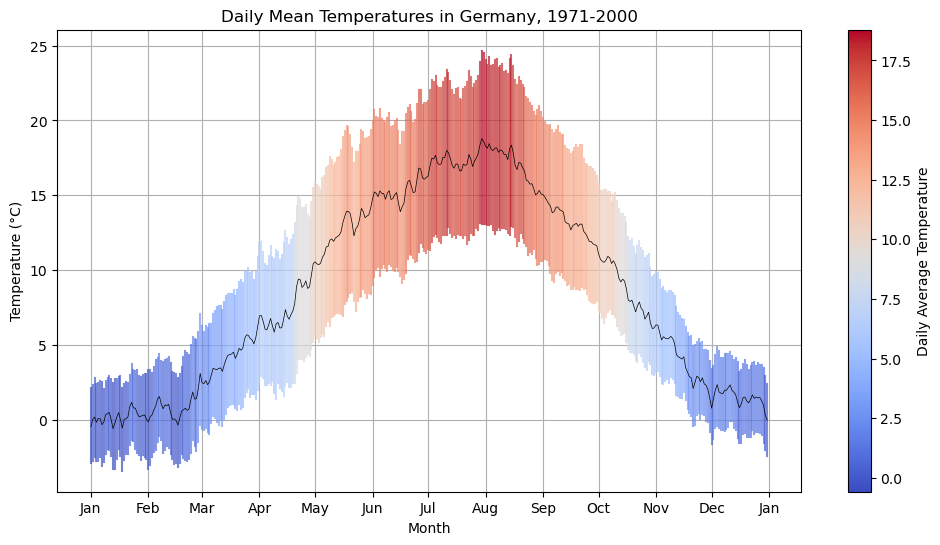

In [38]:
# Normalize for color mapping
norm = Normalize(vmin=daily_avg['tas'].min(), vmax=daily_avg['tas'].max())
colors = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')

# Creating the line range plot with an explicit Axes object
fig, ax = plt.subplots(figsize=(12, 6))

# Uncomment to enable gridlines
ax.grid(True)

for idx, row in daily_avg.iterrows():
    # Plot using pseudo-dates (e.g., 2000-year) for correct x-axis formatting
    pseudo_date = pd.to_datetime('2000-' + row['month_day'])
    ax.plot([pseudo_date, pseudo_date], [row['tasmin'], row['tasmax']], 
            color=colors.to_rgba(row['tas']), alpha=0.7)
    
# Uncomment to plot a line through the value of the 'tas' variable
ax.plot(pd.to_datetime('2000-' + daily_avg['month_day']), daily_avg['tas'], label='tas', color='black', linewidth=0.5)

# Setting x-axis to date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Adding title and labels
ax.set_title('Daily Mean Temperatures in Germany, 1971-2000')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')


# Adding the colorbar
plt.colorbar(colors, ax=ax, label='Daily Average Temperature')

# Uncomment to save your figure as .png
#plt.savefig('../results/daily_mean_temp_germany_1971_2000.png')

plt.show()

## Polar Chart (white background)

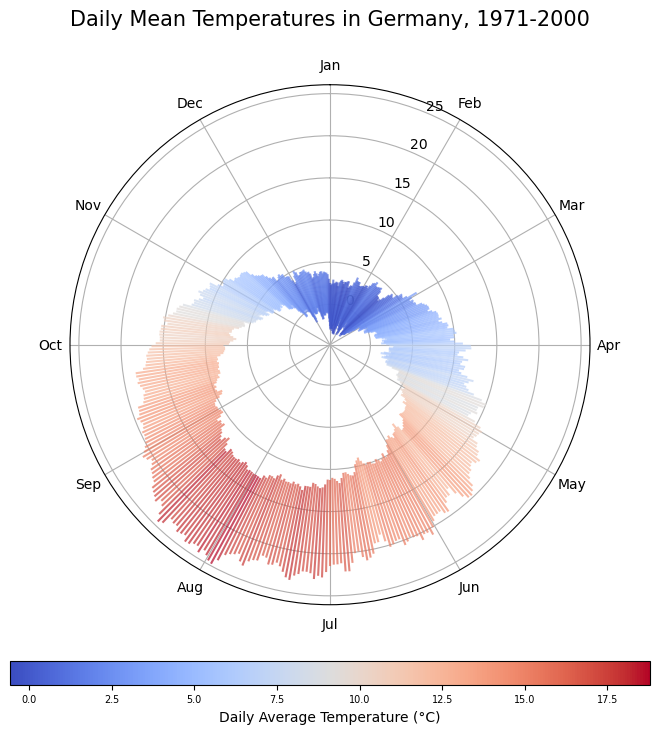

In [39]:
# Normalize for color mapping
norm = Normalize(vmin=daily_avg['tas'].min(), vmax=daily_avg['tas'].max())
colors = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')

# Create the polar plot
fig = plt.figure(figsize=(8, 8))

# Define the position and size of the polar plot
ax = fig.add_axes([0.1, 0.25, 0.8, 0.65], projection='polar')

# Plot each line
for idx, row in daily_avg.iterrows():
    ax.plot([row['radians'], row['radians']], [row['tasmin'], row['tasmax']], 
            color=colors.to_rgba(row['tas']), alpha=0.7)

# Customizing the polar plot
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_xticks([i * (2 * np.pi) / 12 for i in range(12)])  # 12 months
ax.set_xticklabels([month.strftime('%b') for month in pd.date_range(start='2000-01-01', periods=12, freq='M')])

# Add a title
plt.title('Daily Mean Temperatures in Germany, 1971-2000', va='bottom', pad=40, fontsize=15)

# Create an axis for the colorbar below the polar plot
cax = fig.add_axes([0.1, 0.15, 0.8, 0.03])  # For positions and sizing
cbar = plt.colorbar(colors, cax=cax, orientation='horizontal', label='Daily Average Temperature (°C)')

# Adjust the font size of the legend labels
cbar.ax.tick_params(labelsize=7)  

# Uncomment to save the plot as a PNG file
#plt.savefig('Germany_daily_t_climate_circles_1971_2000.png', bbox_inches='tight')

plt.show()

## Polar Chart (black background)

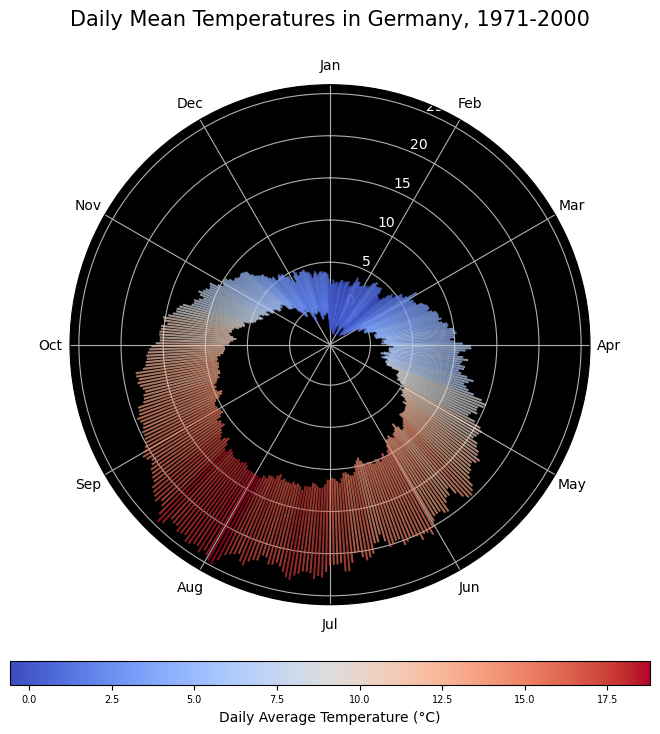

In [40]:
# Normalize for color mapping
norm = Normalize(vmin=daily_avg['tas'].min(), vmax=daily_avg['tas'].max())
colors = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')

# Create the polar plot
fig = plt.figure(figsize=(8, 8))

# Define the position and size of the polar plot
ax = fig.add_axes([0.1, 0.25, 0.8, 0.65], projection='polar')

# Plot each line
for idx, row in daily_avg.iterrows():
    ax.plot([row['radians'], row['radians']], [row['tasmin'], row['tasmax']], 
            color=colors.to_rgba(row['tas']), alpha=0.7)

# Customizing the polar plot
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

ax.set_xticks([i * (2 * np.pi) / 12 for i in range(12)])  # 12 months
ax.set_xticklabels([month.strftime('%b') for month in pd.date_range(start='2000-01-01', periods=12, freq='M')])


# Set the color of the y-axis tick labels to white
ax.yaxis.set_tick_params(labelcolor='white')

# Change the background color to black
ax.set_facecolor('black')


# Add a title
plt.title('Daily Mean Temperatures in Germany, 1971-2000', va='bottom', pad=40, fontsize=15)

# Create an axis for the colorbar below the polar plot
cax = fig.add_axes([0.1, 0.15, 0.8, 0.03])  # For positions and sizing
cbar = plt.colorbar(colors, cax=cax, orientation='horizontal', label='Daily Average Temperature (°C)')

# Adjust the font size of the legend labels
cbar.ax.tick_params(labelsize=7)  

# Uncomment to save the plot as a PNG file
#plt.savefig('Germany_daily_t_black_climate_circles_1971_2000.png', bbox_inches='tight')

plt.show()

## Why do we need to add so many columns?

In [42]:
daily_avg

,month_day,reference_period,tasmin,tas,tasmax,pseudo_date,day_of_year,radians
0,01-01,1971-2000,-2.868339,-0.443160,2.154453,2000-01-01,1,0.017167
1,01-02,1971-2000,-2.714364,0.030127,2.329896,2000-01-02,2,0.034334
2,01-03,1971-2000,-2.510218,0.192951,2.813540,2000-01-03,3,0.051502
3,01-04,1971-2000,-2.764020,-0.158265,2.369320,2000-01-04,4,0.068669
4,01-05,1971-2000,-2.719485,0.098424,2.457711,2000-01-05,5,0.085836
...,...,...,...,...,...,...,...,...
361,12-27,1971-2000,-0.852068,1.506375,3.691148,2000-12-27,362,6.214517
362,12-28,1971-2000,-0.980717,1.275131,3.637778,2000-12-28,363,6.231684
363,12-29,1971-2000,-1.558199,0.977712,3.458436,2000-12-29,364,6.248851
364,12-30,1971-2000,-1.980835,0.298451,2.903217,2000-12-30,365,6.266018


- The addition of 'pseudo_date' and 'radians' columns is necessary for creating polar charts in data visualization. 
- Pseudo Date: A pseudo date standardizes the data across different years for comparison. By using a specific leap year (e.g., 2000), you can include February 29, ensuring that the dataset accounts for each day of the year.
- Radians: The conversion of dates to radians is essential for polar (circular) visualizations. In a polar chart, data points are plotted on a circle, and the position on the circle is determined by the angle in radians. By converting the day of the year to radians, each day gets a unique position on the circle.t.